In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import skimage.segmentation as seg
import skimage.filters as filt
import skimage.morphology as morph
import skimage.draw as draw
from scipy import ndimage
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import cumtrapz
import scipy.ndimage.filters as filters

In [2]:
def show(img_path):
  plt.imshow(img_path)
  plt.axis('off')
  plt.show()
def count_pos(arr):
  count = 0
  for num in arr:
    if num > 0:
        count += 1

  print("Number of positive elements in the array:", count)


In [47]:
def curvature(x, y, xc, yc, r):
    # Shift coordinates to make the center of the circle the origin
    x_shifted = x - xc
    y_shifted = y - yc
    # Calculate distance from each point to the center of the circle
    d = np.sqrt(x_shifted**2 + y_shifted**2)
    # Calculate the curvature only for points inside the circle
    inside_circle = d <= r
    dx_dt = np.gradient(x[inside_circle])
    dy_dt = np.gradient(y[inside_circle])
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    curvature = (dx_dt * d2y_dt2 - d2x_dt2 * dy_dt) / (dx_dt**2 + dy_dt**2)**(3/2)
    # Pad the curvature array with zeros for the points outside the circle
    curvature_padded = np.zeros_like(d)
    curvature_padded[inside_circle] = curvature
    return curvature_padded
def integral_curvature(x, y, xc, yc, r):
    k = curvature(x, y, xc, yc, r)
    return cumtrapz(k, initial=0)

def get_integral_curvature(i,x,y, r):
    # Calculate the integral curvature for a circle centered at (x[i], y[i]) with radius r
    int_curv = integral_curvature(x, y, x[i], y[i], r)[-1]

    return int_curv

    return int_curv
def get_area_measure(contour,i,radius, thresh):
    # Approximate the contour with a circle centered at the current point
    circle_mask = np.zeros_like(gray)
    cv2.circle(circle_mask, (contour[i][0][0], contour[i][0][1]), radius, (255, 255, 255), -1)
    intersection_mask = cv2.bitwise_and(circle_mask, thresh)
    intersection_area = np.sum(intersection_mask) / 255
    circle_area = np.pi * radius ** 2
    intersection_fraction = intersection_area / circle_area
    # Compute the curvature value for the current point
    
    return intersection_fraction


def get_curvature_arc_length(contour,i,x,y,radius,circle_perimeters):
    curvature_arr = []
    # Approximate the contour with a circle centered at the current point
    (cx, cy) = x[i], y[i]
    # Calculate the length of the part of the circle's circumference that is inside the object
    chord_length = 2 * np.sqrt(radius**2 - ((radius**2-(x[i]-cx)**2-(y[i]-cy)**2))/4)
    arc_length = 2 * np.arcsin(chord_length / (2 * radius))
    circle_perimeters.append(arc_length)
    if len(circle_perimeters) > 0:
    # Calculate the average perimeter of the fitted circles
      circle_perimeter = np.mean(circle_perimeters)
    else:
                    # Use the radius as an estimate for the perimeter
      circle_perimeter = 2 * np.pi * radius

                # Calculate perimeter of the contour
    contour_perimeter = cv2.arcLength(contour, True)
                # Calculate the fraction of the circle's perimeter contained inside the object
    fraction = circle_perimeter / contour_perimeter
    arc_len = fraction * arc_length


        
    return arc_len

def get_curvatures(contours, radius_arr,thresh):
    curvature_arr=[]
    
    # Loop over each contour
    for contour in contours:
        curr = []

        # Precompute the coordinates of all points in the contour
        x, y = contour[:, 0, 0], contour[:, 0, 1]
        # Compute the maximum and minimum x and y coordinates of the contour
        min_x, max_x = np.min(x), np.max(x)
        min_y, max_y = np.min(y), np.max(y)
        # Compute the thresholded image for the current contour
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [contour], 0, (255, 255, 255), -1)
        thresh = cv2.bitwise_and(gray, mask)
        # Compute the area measure for each point in the contour
        for radius in radius_arr:
          circle_perimeters = []
          arc_length = 0  # Initialize arc_length to 0
          curr = []
          for i in range(len(contour)):
            curr_area = get_area_measure(contour,i,radius,thresh)
            curr_arc = get_curvature_arc_length(contour,i,x,y,radius,circle_perimeters)
            curr_int = get_integral_curvature(i,x,y, radius)
            curr.append(curr_area)
            #curr.append(curr_arc)
            #curr.append(curr_int)
          curvature_arr.append(curr)
    return curvature_arr
            #print( f'area={curr_area} arc ={curr_arc} curr int = {curr_int}')

In [48]:
# Load the image
img = cv2.imread('13002228285126.png')
# set the new size
new_size = (250, 250)

# resize the image
img = cv2.resize(img, new_size)

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold the image to get a binary image
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Find the contours in the image
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

radius_arr = [10,20,30,40,50,60,70,80,90,100]

currvature_arr = get_curvatures(contours,radius_arr, thresh)



In [49]:
print(currvature_arr)

[[0.4236018034371348, 0.5450339043310922, 0.5895972883968229, 0.516386014574551, 0.508821473749948, 0.441976397651352, 0.43221489447504907, 0.6131397372337888, 0.6480789282701978, 0.5642822903897355, 0.5392918436391494, 0.45382251851364286, 0.5111182980267251, 0.5397661877832663, 0.46018871623731866, 0.4379070242044533, 0.46575601856037635, 0.4277211078465721, 0.5731075880184392, 0.5985723789131424, 0.5126287096435189, 0.48079772102513985, 0.5349104016763843, 0.551474998498576, 0.4655313292289525, 0.39637694611294466, 0.4059262426984584, 0.4473065279023512, 0.6258846154217751, 0.7215897878677014, 0.7301030169805386, 0.6921554854511768, 0.6030287173197154, 0.4931306687721823, 0.5041529287525858, 0.3628108565463481, 0.4519376246778094, 0.5418632882098889, 0.5609618813809164, 0.5291308927625373, 0.5411392892530787, 0.39989707897191834, 0.49220694596521763, 0.5876999118203549, 0.6736435810899783, 0.6699861380840234, 0.6309900563413503, 0.5418632882098889, 0.5441351470053968, 0.456044446346

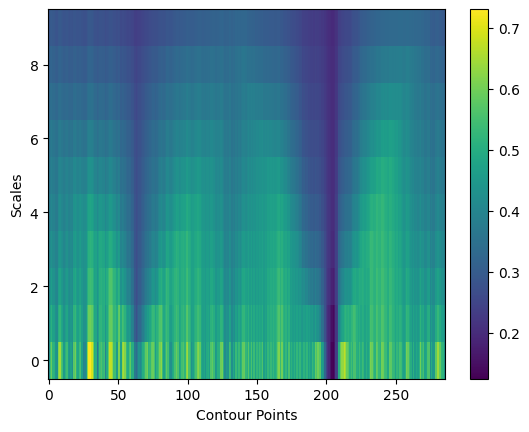

In [50]:
currvature_arr = np.array(currvature_arr)
x = np.arange(currvature_arr.shape[1]) # x-axis is the number of contour points
y = np.arange(currvature_arr.shape[0]) # y-axis is the different scales
X, Y = np.meshgrid(x, y)
plt.pcolormesh(X, Y, currvature_arr)
plt.colorbar()
plt.xlabel('Contour Points')
plt.ylabel('Scales')
plt.show()